In [120]:
from collections import namedtuple
from scipy.spatial.distance import cosine
from copy import deepcopy
from pymystem3 import Mystem
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.model_selection import train_test_split, ShuffleSplit
from collections import defaultdict, Counter
from matplotlib import pyplot as plt

import os
import pandas as pd
import numpy as np
import pycrfsuite
import sklearn_crfsuite
import gensim
import re
import editdistance
import itertools
import nltk
import seaborn

%matplotlib inline

In [70]:
!pip3 install nltk

    100% |████████████████████████████████| 1.2MB 693kB/s ta 0:00:01
  Running setup.py bdist_wheel for nltk ... done
  Stored in directory: /root/.cache/pip/wheels/79/8b/2a/b2da7fce57a1fd9b20b08fa8800c83b6fde62af9e880722e29
Successfully built nltk


In [2]:
np.seterr(all="warn")

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

Маппинг тем

In [3]:
translation = [27, 37, 19, [3, 16, 33], 11, 25, 21, 6, 29, [13, 33], 17, 25, 15, 22, 28, 41, 18, 40, 23, [7, 8], 31,
 20, 17, 32, 25, 38, 14, 25, 36, 25, 4, 24, 5, [7, 8], 25, 12, 9, 25, 24, 26, 30, 35, 13, 3,
 1, 14, 2, 17, 10, 0, 5, 21, 12, -1]
translation[27] = [25, 42, 34, 33, 12]
translation[43] = [3, 34]
translation[22] = [17, 18]
translation[47] = [17, 38]
translation[12] = [15, 27]
translation[43] = [3, 34, 12]
translation[21] = [20, 12]
translation[25] = [38, 12, 25]
translation[42] = [13, 16]
translation[10] = [17, 38]
translation[24] = [25, 37]
del translation[47]
translation_set = []
for element in translation:
    try:
        translation_set.append(set(element))
    except:
        translation_set.append({element})
translation = translation_set[:]

In [4]:
len(translation)

53

In [5]:
translation[48]

{0}

In [6]:
true_labels = set()
for i in translation:
    for l in i:
        true_labels.add(l)
len(true_labels)

43

Лемматизация

In [7]:
mystem = Mystem()

def stem(s):
    return [(e['text'].strip(), \
             e['analysis'][0]['lex'] \
                 if 'analysis' in e and len(e['analysis']) > 0 else '', \
             re.match('^([A-Z]+)', e['analysis'][0]['gr']).group(0) \
                 if 'analysis' in e and len(e['analysis']) > 0 else '', \
             ','.join(set(re.findall(r"[\w']+", e['analysis'][0]['gr'])[1:])) \
                 if 'analysis' in e and len(e['analysis']) > 0 else '')\
             for e in mystem.analyze(s) if len(e['text'].strip()) > 0]

def get_pos_tag(word):
    temp = stem(word)[0]
    return temp[2]

In [8]:
get_pos_tag("брать")

'V'

Загрузка данных

In [9]:
with open("./data/vw.txt") as fin:
    text = fin.read()
topics = pd.read_pickle("./data/topics_assessors.pkl")
ptdw = pd.read_pickle("./data/ptdw")
w2v_model = gensim.models.Word2Vec.load("./data/transcriptions_w2v")

In [10]:
w2v_model["банк_S"].shape

(300,)

In [11]:
"банк_S" in w2v_model

True

In [12]:
stem("банк_тинькофф")

[('банк', 'банк', 'S', 'вин,ед,неод,муж,им'),
 ('_', '', '', ''),
 ('тинькофф', 'тинькофф', 'S', 'вин,ед,неод,муж,им')]

Их предобработка

In [13]:
phrases, topic_probs, labels = [], [], []
for index, line in enumerate(text.split("\n")):
    temp = line.split()
    phrase_id = temp[0]
    phrase = temp[2:]
    probs = ptdw[phrase_id].as_matrix()
    phrase_size = 0
    if len(probs.shape) < 2:
        phrase_size = 1
        probs = np.expand_dims(probs, axis=1)
    else:
        phrase_size = probs.shape[1]
    if phrase_size != len(phrase):
        raise
    if phrase_id in topics:
        phrases.append(phrase)
        topic_probs.append(probs)
        labels.append(topics[phrase_id])

In [14]:
stem(" ".join(phrases[1]))

[('сказать', 'сказать', 'V', 'сов,инф,пе'),
 ('кредит', 'кредит', 'S', 'вин,ед,неод,муж,им'),
 ('какой', 'какой', 'APRO', 'вин,ед,неод,жен,твор,муж,дат,им,пр,род'),
 ('банка', 'банк', 'S', 'муж,неод,род,ед'),
 ('_', '', '', ''),
 ('другой', 'другой', 'APRO', 'вин,ед,неод,жен,твор,муж,дат,им,пр,род')]

In [15]:
def argmax_topic_segmentation(topic_prob):
    return [np.argmax(topic_prob[:, i]) for i in range(topic_prob.shape[1])]

In [16]:
[translation[i] for i in argmax_topic_segmentation(topic_probs[1])]

[{2}, {22}, {12}, {27}]

In [17]:
phrases[0]

['здравствовать',
 'звать',
 'имя',
 'сотрудник',
 'банка',
 'тинькофф',
 'предложение',
 'повод',
 'банковский',
 'карта',
 'пара',
 'минута']

In [18]:
topic_probs[1].shape

(53, 4)

Генерация фичей

In [19]:
def meta_word2vec(meta_word, w2v_model):
    meta_word_vector = np.zeros(300)
    length = 0
    for w in meta_word.split("_"):
        with_pos = w + "_" + get_pos_tag(w)
        if with_pos in w2v_model:
            meta_word_vector += w2v_model[with_pos]
            length += 1
    if length == 0:
        return None
    return meta_word_vector / length
    
def distance_vector(phrase, index, w2v_model):
    source_vector = meta_word2vec(phrase[index], w2v_model)
    distances = []
    for word in phrase:
        distances.append(cosine(metaword2vec(word), source_vector))
    return distances

In [20]:
def phrase_to_features(phrase, phrase_index, topic_prob=None, w2v_model=None, random_noise=False):
    features = []
    for word_index, word in enumerate(phrase):
        word_features = {}
        #word_features["word"] = word
        
        # just for lulz
        if random_noise:
            rand_features = np.random.normal(size=300)
            for i in range(300):
                word_features["random shit {}".format(i)] = rand_features[i]
        if topic_prob[phrase_index] is not None:
            for t in range(topic_prob[phrase_index].shape[0]):
                word_features["topic {}".format(t)] = topic_prob[phrase_index][t][word_index]
        if w2v_model is not None:
            meta_word_vector = meta_word2vec(word, w2v_model)
            if meta_word_vector is not None:
                for i in range(len(meta_word_vector)):
                    word_features["w2v {}".format(i)] = meta_word_vector[i]
            try:
                if meta_word_vector is not None:
                    if word_index > 0:
                        left_word = meta_word2vec(phrase[word_index - 1], w2v_model)
                        if left_word is not None:
                            word_features["-1 w2v"] = cosine(left_word, meta_word_vector)
                    if word_index < len(phrase) - 1:
                        right_word = meta_word2vec(phrase[word_index + 1], w2v_model)
                        if right_word is not None:
                            word_features["+1 w2v"] = cosine(right_word, meta_word_vector)
            except:
                print(phrase)
                print(word, word_index)
                raise
        features.append(word_features)
    return features

In [21]:
a = np.array([2, 3, np.nan, 5])

In [22]:
a = np.array([np.inf, 3, 4])

In [23]:
np.sum(a)

inf

In [24]:
a / 0.0

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([ inf,  inf,  inf])

In [25]:
topic_probs[11][:, 0].shape

(53,)

Функции для оценивания качества модели

In [113]:
def transform_to_symbols(seq):
    return [chr(x + ord('a')) for x in seq]

def squash_sequence(seq):
    result = []
    if len(seq) == 0:
        return result
    result = [seq[0]]
    for x in seq[1:]:
        if x != result[-1]:
            result.append(x)
    return result

def topics_edit_distance(pred_seq, true_seq, translation):
    distances = np.zeros(shape=(len(pred_seq) + 1, len(true_seq) + 1))
    for i in range(len(pred_seq) + 1):
        distances[i, 0] = i
    for i in range(len(true_seq) + 1):
        distances[0, i] = i
    for i in range(1, len(pred_seq) + 1):
        for j in range(1, len(true_seq) + 1):
            exchange_weight = 1
            if true_seq[j - 1] in translation[pred_seq[i - 1]]:
                exchange_weight = 0
            distances[i, j] = min(distances[i - 1, j] + 1, distances[i, j - 1] + 1, distances[i - 1, j - 1] + exchange_weight)
    return distances[-1, -1]

def get_boundaries(label_seq):
    prev_label = label_seq[0]
    boundaries = ["0"]
    for label in label_seq[1:]:
        if label != prev_label:
            prev_label = label
            boundaries.append("1")
        else:
            boundaries.append("0")
    return "".join(boundaries)
    
def wd_distance(pred_seq, true_seq):
    pred_boundaries = get_boundaries(pred_seq)
    true_boundaries = get_boundaries(true_seq)
    num_true_segments = 1
    for i in true_boundaries:
        if i == "1":
            num_true_segments += 1
    k = len(pred_seq) // (2 * num_true_segments)
    return nltk.segmentation.windowdiff(true_boundaries, pred_boundaries, k)

def smoothing_weigths(window_size):
    weights = [i * i for i in range(-window_size, window_size + 1)]
    weights[window_size] = 1.0
    weights = [1 / x for x in weights]
    return weights
    
def topic_smoothing(topic_probs, window_size=6, num_iterations=10):
    smoothed_topic_probs = deepcopy(topic_probs)
    for i in range(num_iterations):
        old_topic_probs = deepcopy(smoothed_topic_probs)
        for d in range(len(topic_probs)):
            document_size = smoothed_topic_probs[d].shape[1]
            for w in range(document_size):
                window_start = max(0, w - window_size)
                window_end = min(document_size, w + window_size + 1)
                context_topics = old_topic_probs[d][:, window_start: window_end]
                context_weights = smoothing_weigths(window_size)[window_size - (w - window_start): 
                                                                 window_size + (window_end - w)]
                #print(context_weights)
                smoothed_topic_probs[d][:, w] = np.sum(context_weights * context_topics, axis=1)
                #bug, fix this shit
                if np.sum(smoothed_topic_probs[d][:, w]) == 0.0:
                    pass
                    #print(i, d, w)
                smoothed_topic_probs[d][:, w] = smoothed_topic_probs[d][:, w] / np.sum(
                    smoothed_topic_probs[d][:, w])
    return smoothed_topic_probs

def evaluate_topics(pred, true, translation):
    acc, edit_distance, window_diff = 0.0, 0.0, 0.0
    true_labels_statistics = defaultdict(float)
    pred_labels_statistics = defaultdict(float)
    intersection_labels_statistics = defaultdict(float)
    for index, pred_seq in enumerate(pred):
        seq_acc = 0.0
        edit_distance += topics_edit_distance(pred_seq, true[index], translation) / len(true[index])
        window_diff += wd_distance(pred_seq, true[index])
        true_seq = true[index]
        for seq_index, pred_label in enumerate(pred_seq):
            true_label = true_seq[seq_index]
            for label in translation[pred_label]:
                pred_labels_statistics[label] += 1.0
                if true_label in translation[pred_label]:
                    intersection_labels_statistics[label] += 1.0
                    true_labels_statistics[label] += 1.0
            if true_label in translation[pred_label]:
                seq_acc += 1.0
        seq_acc /= len(pred_seq)
        acc += seq_acc
    f1_scores = defaultdict(float)
    for label in true_labels_statistics.keys():
        precision, recall = 0.0, 0.0
        if pred_labels_statistics[label] > 0:
            precision = intersection_labels_statistics[label] / pred_labels_statistics[label]
        if true_labels_statistics[label] > 0:
            recall = intersection_labels_statistics[label] / true_labels_statistics[label]
        if not(precision == 0.0 and recall == 0.0):
            f1_scores[label] = 2 * precision * recall / (precision + recall) * 1.0 / (true_labels_statistics[label]) 
    return acc / len(pred), edit_distance / len(pred), sum(f1_scores.values()), window_diff / len(pred)

In [69]:
get_boundaries(labels[0])

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]

In [44]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

In [27]:
def test(num_examples=100):
    translation = {str(i): {str(i)} for i in range(0, 10)}
    for _ in range(num_examples):
        first = np.random.random_integers(0, 9, 100)
        second = np.random.random_integers(0, 9, 200)
        first = squash_sequence(first)
        second = squash_sequence(second)
        first = "".join(map(str, first))
        second = "".join(map(str, second))
        assert editdistance.eval(first, second) == topics_edit_distance(first, second, translation)

In [28]:
test()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 9 + 1) instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(0, 9 + 1) instead
  """


In [ ]:
%%time
scores = {}
for num_iterations in range(1, 11):
    for window_size in range(1, 8):
        smoothed_topic_probs = topic_smoothing(topic_probs, window_size, num_iterations)
        smoothed_results = [argmax_topic_segmentation(smoothed_topic_probs[i]) for i in range(len(smoothed_topic_probs))]
        score = evaluate_topics(smoothed_results, labels, translation)
        scores[(num_iterations, window_size)] = score

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide


CPU times: user 1min 45s, sys: 1.6 s, total: 1min 46s
Wall time: 1min 45s


In [117]:
sorted(scores.items(), key=lambda x: x[1][1])[:10]

[((3, 5),
  (0.5254892958915611,
   0.47424240651107707,
   0.47117497466786334,
   0.22765350967128445)),
 ((5, 7),
  (0.5254557852788019,
   0.47427335620178857,
   0.5057914823461889,
   0.18583052581433726)),
 ((3, 6),
  (0.5255064503176108,
   0.47427343324619342,
   0.4748838256203543,
   0.2230371764644806)),
 ((3, 4),
  (0.5254406392265003,
   0.47432222381841377,
   0.46910249968862877,
   0.23363646055511142)),
 ((3, 7),
  (0.525364633502031,
   0.47448856922006932,
   0.47651324914526033,
   0.2214550824694867)),
 ((4, 4),
  (0.5251910431188959,
   0.47458085175108899,
   0.47794427638979736,
   0.21136916635841307)),
 ((4, 6),
  (0.5251448005614643,
   0.47465357067123842,
   0.4920341859136894,
   0.2023436358206062)),
 ((5, 6),
  (0.5251106432832544,
   0.4746787246487934,
   0.5038869914241904,
   0.1890256463564023)),
 ((4, 7),
  (0.5251119893501123,
   0.47475802380523924,
   0.4975765714940022,
   0.2012534738027519)),
 ((6, 5),
  (0.5244561520038119,
   0.47527298947

In [128]:
temp = {}
for num_iterations, window_size in scores.keys():
    if window_size == 5:
        temp[num_iterations] = (scores[(num_iterations, window_size)])

In [145]:
def plot_smoothing_graphic(window_size):
    temp = {}
    for num_iterations, w in scores.keys():
        if w == window_size:
            temp[num_iterations] = (scores[(num_iterations, w)])
    plt.figure(figsize=(15, 8))
    plt.plot(list(temp.keys()), list(map(lambda x: x[0], temp.values())), label="accuracy")
    plt.plot(list(temp.keys()), list(map(lambda x: x[1], temp.values())), label="f1 score")
    plt.plot(list(temp.keys()), list(map(lambda x: x[2], temp.values())), label="edit distance")
    plt.plot(list(temp.keys()), list(map(lambda x: x[3], temp.values())), label="WD")
    plt.xlabel("number of iterations")
    plt.legend(title="window size="+str(window_size))
    plt.show()

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


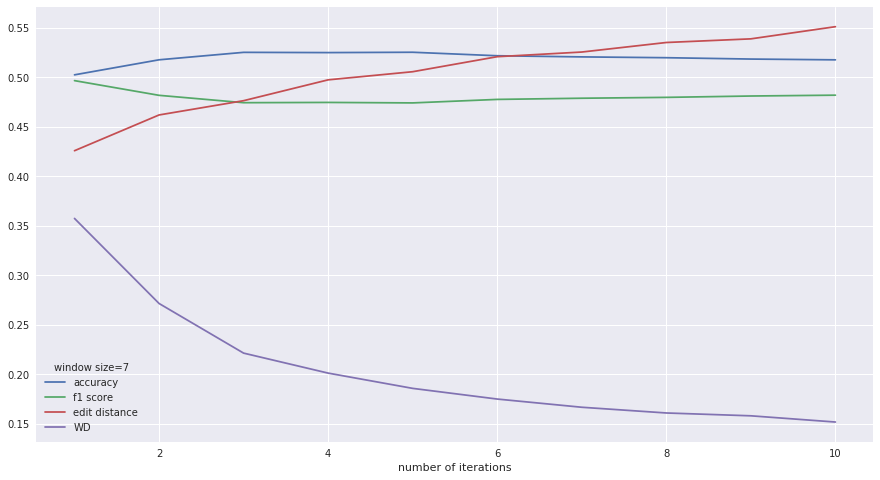

In [147]:
plot_smoothing_graphic(7)

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


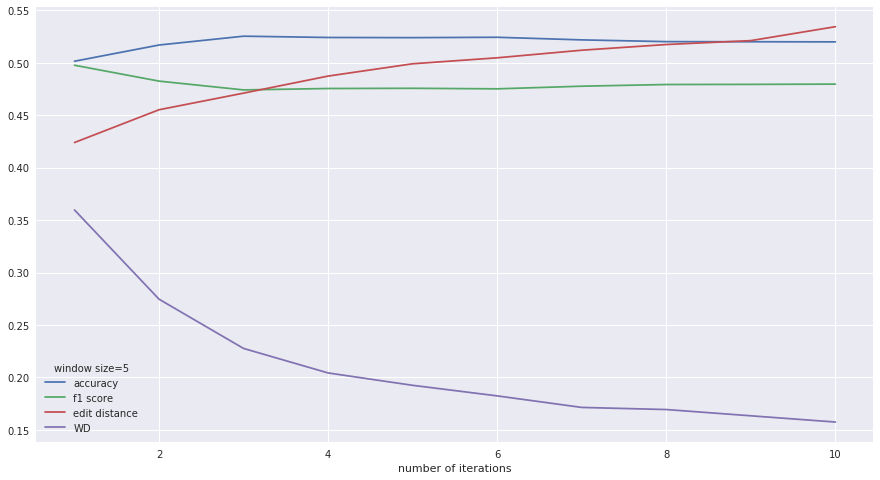

In [146]:
plot_smoothing_graphic(5)

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


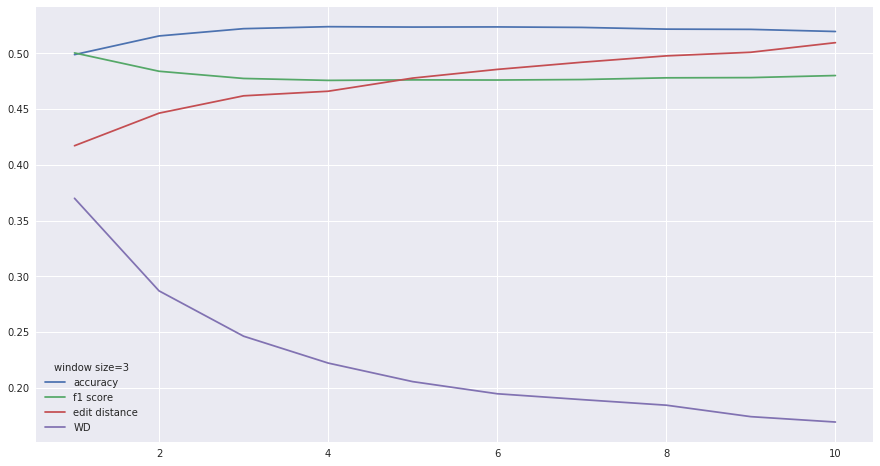

In [144]:
plot_smoothing_graphic(3)

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


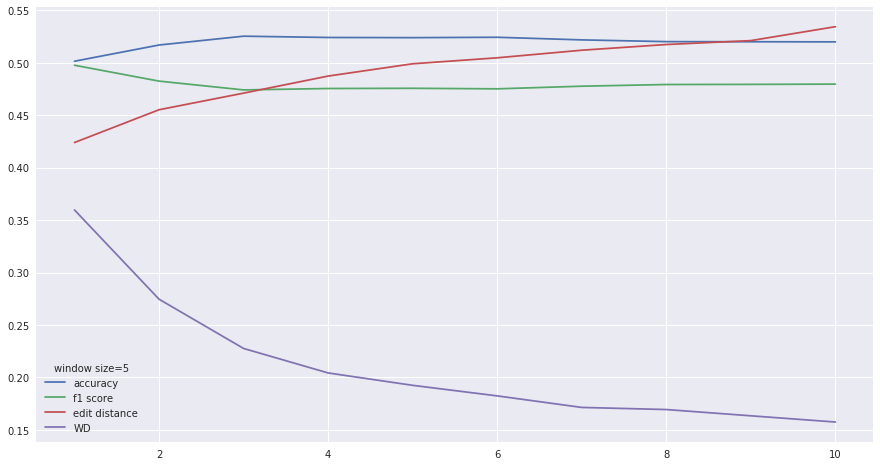

In [136]:
plt.figure(figsize=(15, 8))
plt.plot(list(temp.keys()), list(map(lambda x: x[0], temp.values())), label="accuracy")
plt.plot(list(temp.keys()), list(map(lambda x: x[1], temp.values())), label="f1 score")
plt.plot(list(temp.keys()), list(map(lambda x: x[2], temp.values())), label="edit distance")
plt.plot(list(temp.keys()), list(map(lambda x: x[3], temp.values())), label="WD")

plt.legend(title="window size=5")

In [ ]:
temp = {}
for num_iterations, window_size in scores.keys():
    if window_size == 6:
        temp[num_iterations] = (scores[(num_iterations, window_size)])
        
plt.figure(figsize=(15, 8))
plt.plot(list(temp.keys()), list(map(lambda x: x[0], temp.values())), label="accuracy")
plt.plot(list(temp.keys()), list(map(lambda x: x[1], temp.values())), label="f1 score")
plt.plot(list(temp.keys()), list(map(lambda x: x[2], temp.values())), label="edit distance")
plt.plot(list(temp.keys()), list(map(lambda x: x[3], temp.values())), label="WD")

plt.legend(title="window size=5")

In [129]:
list(map(lambda x: x[0], temp.keys()))

TypeError: 'int' object is not subscriptable

In [31]:
smoothed_topic_probs = topic_smoothing(topic_probs, 3, 5)

0 11 0
0 11 1
0 42 0
0 42 1
0 42 2
0 87 0
0 191 20
0 217 0
0 217 1
0 217 2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


0 455 0
0 523 0
0 523 1
0 535 9


In [32]:
#Some p(t|w,d) vectors are all-zero, in this case we ignore their smoothed versions
bad_indexes = []
for i, d in enumerate(smoothed_topic_probs):
    if np.isnan(np.min(d)):
        bad_indexes.append(i)
for i in bad_indexes:
    smoothed_topic_probs[i] = topic_probs[i]

In [33]:
for i, d in enumerate(smoothed_topic_probs):
    if np.isnan(np.min(d)):
        print(i)

In [34]:
#sorted(scores.items(), key=lambda x: x[1][1])[:10]

In [35]:
np.sum(smoothed_topic_probs[0]) / smoothed_topic_probs[0].shape[1]

0.99999992052714026

In [36]:
smoothed_topic_probs[0].shape

(53, 12)

In [37]:
not_smoothed_results = [argmax_topic_segmentation(topic_probs[i]) for i in range(len(topic_probs))]
smoothed_results = [argmax_topic_segmentation(smoothed_topic_probs[i]) for i in range(len(smoothed_topic_probs))]

In [109]:
evaluate_topics(smoothed_results, labels, translation)

(0.5243767059446883,
 0.47546850808359253,
 0.4750695550031161,
 0.20634379848700873)

In [110]:
evaluate_topics(not_smoothed_results, labels, translation)

(0.3522237890528806,
 0.64763230919692771,
 0.4432006256116683,
 0.7044146486922588)

In [40]:
new2new_translation = {i: {i} for i in range(-1, 43)}

5-fold кросс валидация модели

In [105]:
Param = namedtuple("Param", field_names=["name", "value"])

CRF_PARAMS = {
    "topics": [
        Param("Topics disabled", [None for i in range(len(phrases))]), 
        Param("Topics not smoothing", topic_probs),
        Param("Topics smoothing", smoothed_topic_probs),
    ],
    "w2v": [
        Param("w2v disabled", None), 
        Param("w2v enabled", w2v_model),
    ],
}

In [106]:
def generate_data(phrases, params):
    X_data = [phrase_to_features(phrases[i], i, *map(lambda x: x.value, params)) for i in range(len(phrases))]
    y_data = [[str(x) for x in labels[i]] for i in range(len(labels))]
    return X_data, y_data

In [111]:
%%time
params_list = itertools.product(*CRF_PARAMS.values())
temp = []
params_scores = {}
rs = ShuffleSplit(n_splits=5, random_state=42)
splits_indexes = list(rs.split(list(range(len(phrases)))))
for params in params_list:
    X_data, y_data = generate_data(phrases, params)
    accuracy_scores = []
    f1_scores = []
    edit_distance_scores = []
    window_diff_scores = []
    for train_indexes, test_indexes in splits_indexes:
        X_train, X_test, y_train, y_test = [], [], [], []
        for train_index in train_indexes:
            X_train.append(X_data[train_index])
            y_train.append(y_data[train_index])
        for test_index in test_indexes:
            X_test.append(X_data[test_index])
            y_test.append(y_data[test_index])
        crf = sklearn_crfsuite.CRF(algorithm="lbfgs", max_iterations=2000, verbose=False, 
                               all_possible_transitions=True, all_possible_states=True)
        crf.fit(X_train, y_train)
        print(len(crf.state_features_))
        print(len(crf.transition_features_))
        temp = crf.transition_features_.keys()
        y_pred = crf.predict(X_test)
        accuracy_scores.append(metrics.flat_accuracy_score(y_test, y_pred))
        f1_scores.append(metrics.flat_f1_score(y_test, y_pred, average="weighted"))
        y_test = [list(map(int, x)) for x in y_test]
        y_pred = [list(map(int, x)) for x in y_pred]
        my_scores = evaluate_topics(y_pred, y_test, translation=new2new_translation)
        edit_distance_scores.append(my_scores[1])
        window_diff_scores.append(my_scores[-1])
    accuracy_score = np.mean(accuracy_scores)
    f1_score = np.mean(f1_scores)
    edit_distance_score = np.mean(edit_distance_scores)
    window_diff_score = np.mean(window_diff_scores)
    output_string = "{} ; "* len(params) + " --- accuracy: {}, f1: {}, edit distance: {}, window_diff: {}"
    print(output_string.format(*map(lambda x: x.name, params), accuracy_score, f1_score, 
                               edit_distance_score, window_diff_score))
    params_scores[tuple(map(lambda x: x.name, params))] = accuracy_score, f1_score, edit_distance_score, window_diff_score

0
1936


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0
1936
0
1936
0
1936
0
1936
Topics disabled ; w2v disabled ;  --- accuracy: 0.14458534779026927, f1: 0.0374121640631434, edit distance: 0.8978966856479607, window_diff: 0.12019733379811504
6756
1936


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


6751
1936
6738
1936
6754
1936
6760
1936
Topics disabled ; w2v enabled ;  --- accuracy: 0.6007695102624682, f1: 0.5914351510525744, edit distance: 0.38054240348305657, window_diff: 0.13826909331093648
2332
1936
2332
1936
2332
1936
2332
1936
2332
1936
Topics not smoothing ; w2v disabled ;  --- accuracy: 0.5640789019958479, f1: 0.5410330607913052, edit distance: 0.4448148550036022, window_diff: 0.10473729249443804
9088
1936
9083
1936
9070
1936
9086
1936
9092
1936
Topics not smoothing ; w2v enabled ;  --- accuracy: 0.6204920426665609, f1: 0.6146896651350309, edit distance: 0.358483342676197, window_diff: 0.1360052982058923
2332
1936
2332
1936
2332
1936
2332
1936
2332
1936
Topics smoothing ; w2v disabled ;  --- accuracy: 0.5206092130160641, f1: 0.49610678094267396, edit distance: 0.47313288336341913, window_diff: 0.11758276536447643
9088
1936
9083
1936
9070
1936
9086
1936
9092
1936
Topics smoothing ; w2v enabled ;  --- accuracy: 0.6337703978174387, f1: 0.6294136762351632, edit distance: 0.3

In [116]:
params_scores

{('Topics disabled', 'w2v disabled'): (0.14458534779026927,
  0.037412164063143398,
  0.89789668564796066,
  0.12019733379811504),
 ('Topics disabled', 'w2v enabled'): (0.60076951026246816,
  0.59143515105257438,
  0.38054240348305657,
  0.13826909331093648),
 ('Topics not smoothing', 'w2v disabled'): (0.56407890199584787,
  0.5410330607913052,
  0.44481485500360218,
  0.10473729249443804),
 ('Topics not smoothing', 'w2v enabled'): (0.62049204266656088,
  0.61468966513503087,
  0.35848334267619703,
  0.1360052982058923),
 ('Topics smoothing', 'w2v disabled'): (0.52060921301606411,
  0.49610678094267396,
  0.47313288336341913,
  0.11758276536447643),
 ('Topics smoothing', 'w2v enabled'): (0.63377039781743871,
  0.6294136762351632,
  0.36092359604218266,
  0.14516591401082582)}

In [62]:
params = [Param("Topics smoothing", smoothed_topic_probs), Param("w2v enabled", w2v_model),]
X_data, y_data = generate_data(phrases, params)

In [63]:
%%time
crf = sklearn_crfsuite.CRF(algorithm="lbfgs", max_iterations=2000, verbose=False, 
                               all_possible_transitions=True, all_possible_states=True)
crf.fit(X_data, y_data)

CPU times: user 1min 34s, sys: 36 ms, total: 1min 34s
Wall time: 1min 34s


In [99]:
for phrase in phrases[:10]:
    print(" ".join(phrase), end="\n\n")

здравствовать звать имя сотрудник банка тинькофф предложение повод банковский карта пара минута

сказать кредит какой банка_другой

ответ данный момент возможность получить кредитный карта высокий_статус виза платинум первоначальный кредитный_лимит тысяча рубль беспроцентный_период день карта выпускаться срок год доставляться неактивированный вид вместе полный документ_пакет возможность ознакомиться ваш индивидуальный_условие прежде принимать какой решение карта не активировать поэтому решение повод активация принимать почему задать вопрос повод кредит потому данный момент этот карта баланс_перевод услуга абсолютно бесплатный помощь наш карта возможность частично полностью погасить задолженность ваш иной кредит более выгодный условие предоставить беспроцентный_период месяц месяц погашать процент такой образ сэкономить свой денежный средство такой предложение

процент интересный который годовой перевод

смотреть перевод перевод услуга абсолютно бесплатный течение месяц не платить надо к

In [100]:
labels[:10]

[[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2],
 [3, 3, 3, 3],
 [-1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  4,
  4,
  4,
  5,
  5,
  5,
  5,
  6,
  6,
  -1,
  -1,
  -1,
  -1,
  7,
  7,
  7,
  7,
  7,
  7,
  9,
  9,
  9,
  9,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  -1,
  -1,
  3,
  3,
  3,
  -1,
  -1,
  -1,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  12,
  12],
 [13, 13, 13, 13, 13],
 [11,
  11,
  11,
  11,
  11,
  11,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6],
 [13,
  13,
  13,
  13,
  13,
  -1,
  -1,
  6,
  6,
  6,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13],
 [-1,
  -1,
  -1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  10,
  10,
  10,
  14,
  1

In [101]:
crf.predict(X_data[:10])

[['0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '2', '2'],
 ['3', '3', '3', '3'],
 ['-1',
  '-1',
  '-1',
  '1',
  '1',
  '1',
  '1',
  '4',
  '4',
  '4',
  '5',
  '5',
  '5',
  '5',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '7',
  '7',
  '7',
  '7',
  '7',
  '7',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '3',
  '3',
  '3',
  '3',
  '3',
  '-1',
  '-1',
  '-1',
  '11',
  '11',
  '11',
  '11',
  '11',
  '11',
  '11',
  '11',
  '11',
  '11',
  '11',
  '11',
  '11',
  '11',
  '11',
  '11',
  '11',
  '11',
  '11',
  '11',
  '11',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '12',
  '12'],
 ['13', '13', '13', '13', '13'],
 ['11',
  '11',
  '11',
  '11',
  '11',
  '11',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6',
  '6'],
 ['13',
  '13',
  '13',
  '13',
  '13

In [64]:
print(crf.score(X_data, y_data))
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

0.919475655431
Top likely transitions:
12     -> 12      5.240397
10     -> 10      5.240163
18     -> 18      5.228113
21     -> 21      5.199127
3      -> 3       5.030366
17     -> 17      4.954965
14     -> 14      4.929268
20     -> 20      4.921449
6      -> 6       4.746184
16     -> 16      4.697310
24     -> 24      4.671358
11     -> 11      4.645574
13     -> 13      4.582466
32     -> 32      4.552639
1      -> 1       4.551282
25     -> 25      4.550577
9      -> 9       4.486413
22     -> 22      4.437221
34     -> 34      4.367108
39     -> 39      4.337941

Top unlikely transitions:
20     -> 1       -0.422051
1      -> 21      -0.426728
6      -> 3       -0.432130
12     -> 9       -0.435591
21     -> 35      -0.435977
23     -> 17      -0.438011
13     -> 6       -0.439768
14     -> 1       -0.450187
12     -> 6       -0.460765
14     -> 12      -0.464320
23     -> 12      -0.486743
21     -> 10      -0.495761
2      -> 10      -0.502963
6      -> 10      -0.519434
21

In [65]:
for i in range(len(translation)):
    print(i, translation[i])

0 {27}
1 {37}
2 {19}
3 {16, 33, 3}
4 {11}
5 {25}
6 {21}
7 {6}
8 {29}
9 {33, 13}
10 {17, 38}
11 {25}
12 {27, 15}
13 {22}
14 {28}
15 {41}
16 {18}
17 {40}
18 {23}
19 {8, 7}
20 {31}
21 {20, 12}
22 {17, 18}
23 {32}
24 {25, 37}
25 {25, 12, 38}
26 {14}
27 {33, 34, 42, 12, 25}
28 {36}
29 {25}
30 {4}
31 {24}
32 {5}
33 {8, 7}
34 {25}
35 {12}
36 {9}
37 {25}
38 {24}
39 {26}
40 {30}
41 {35}
42 {16, 13}
43 {34, 3, 12}
44 {1}
45 {14}
46 {2}
47 {10}
48 {0}
49 {5}
50 {21}
51 {12}
52 {-1}


In [66]:
print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
1.851708 29       topic 8
1.748815 11       topic 4
1.692683 15       topic 12
1.584614 20       topic 21
1.552952 30       topic 40
1.550972 18       topic 16
1.547463 10       topic 47
1.500569 40       topic 17
1.487429 24       topic 31
1.457597 -1       topic 21
1.426853 36       topic 28
1.405204 16       topic 3
1.341955 -1       topic 48
1.339767 22       topic 13
1.302784 -1       topic 30
1.261673 27       topic 0
1.257291 -1       topic 32
1.255118 -1       topic 16
1.228484 13       topic 9
1.205266 38       topic 25
1.171660 26       topic 39
1.163132 4        topic 30
1.134237 37       topic 1
1.127287 -1       topic 46
1.111923 1        topic 51
1.103471 42       topic 43
1.094385 25       topic 27
1.061686 28       topic 14
1.029788 -1       topic 22
1.027588 12       topic 41

Top negative:
-0.449883 10       topic 12
-0.469469 20       w2v 51
-0.476114 20       topic 52
-0.478978 17       w2v 45
-0.479291 14       w2v 7
-0.479609 1        -1 w2v
-0.48011

0.402454675538


In [25]:
len(phrases)

593

In [43]:
values = set()
for pair in list(temp):
    a, b = int(pair[0]), int(pair[1])
    values.add(a)
    values.add(b)

In [44]:
max(values)

42

In [45]:
min(values)

-1

In [22]:
topic_probs[0].shape

(53, 12)